# Install & Import Packages

In [ ]:
!pip install sentence_transformers
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install timm fairscale

In [1]:
import os
import pickle

import clip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode 
from tqdm import tqdm

device = torch.device("mps")
device

/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device(type='mps')

# Data

We load the train, dev, and test data.

In [2]:
df_train = pd.read_csv("./data/train.tsv", sep="\t")
df_dev = pd.read_csv("./data/dev.tsv", sep="\t")
df_test = pd.read_csv("./data/test.tsv", sep="\t")

# Recode image path
df_train["image"] = df_train["image"].apply(lambda s: os.path.join("data", s))
df_dev["image"] = df_dev["image"].apply(lambda s: os.path.join("data", s))
df_test["image"] = df_test["image"].apply(lambda s: os.path.join("data", s))

# Recode label to 0/1
df_train["label"] = df_train["label"].apply(lambda s: 1 if s == "informative" else 0)
df_dev["label"] = df_dev["label"].apply(lambda s: 1 if s == "informative" else 0)
df_test["label"] = df_test["label"].apply(lambda s: 1 if s == "informative" else 0)

# Evaluation

We define the evaluation function `score()`.

In [3]:
def score(y_true: np.ndarray, y_pred: np.ndarray, y_pred_proba: np.ndarray) -> None:
    """
    Evaluates the model, printing the accuracy, classification report,
    confusion matrix, ROC curve, and AUC score.

    Args:
        `y_true` (np.ndarray): True labels

        `y_pred` (np.ndarray): Predicted labels
        
        `y_pred_proba` (np.ndarray): Predicted label probabilities

    Usage Example:
        Consider input data `X` of shape (n_samples, n_features), and labels
        `y` of shape (n_samples,).
        >>> from sklearn.linear_model import LogisticRegression
        >>> clf = LogisticRegression(random_state=42)
        >>> clf.fit(X, y)
        >>> y_pred = clf.predict(X)
        >>> y_pred_proba = clf.predict_proba(X)
        >>> score(y, y_pred, y_pred_proba)
    """
    # Accuracy
    print(f"Accuracy: {metrics.accuracy_score(y_true=y_true, y_pred=y_pred)}\n")
        
    # Classification report
    print(metrics.classification_report(y_true=y_true, y_pred=y_pred, digits=3))

    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    # Confusion matrix
    cm = metrics.confusion_matrix(y_true=y_true, y_pred=y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=ax1, cmap=plt.cm.Blues, cbar=False)
    ax1.set(xlabel="Pred", ylabel="True", xticklabels=[0, 1], yticklabels=[0, 1], title="Confusion Matrix")

    # ROC curve/AUC score
    fpr, tpr, _ = metrics.roc_curve(y_true=y_true, y_score=y_pred_proba[:, 1], pos_label=1)
    auc_score = metrics.roc_auc_score(y_true=y_true, y_score=y_pred_proba[:, 1])
    ax2.plot(fpr, tpr, color="red", label=f"ROC Curve (AUC = {round(auc_score, 3)})")
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="best")

# Experiments

## Simple Baseline

We use a simple majority-class baseline. The majority class is determined based on the train data.

In [4]:
def simple_baseline() -> int:
    """
    Returns the majority label in the train data.
    """
    return df_train["label"].value_counts().sort_values(ascending=False).index[0]

majority_label = simple_baseline()
print(f"Majority Label: {majority_label}")

Majority Label: 1


We evaluate the baseline on the train data.

Accuracy: 0.6129482657260436

              precision    recall  f1-score   support

           0      0.000     0.000     0.000      5267
           1      0.613     1.000     0.760      8341

    accuracy                          0.613     13608
   macro avg      0.306     0.500     0.380     13608
weighted avg      0.376     0.613     0.466     13608



/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

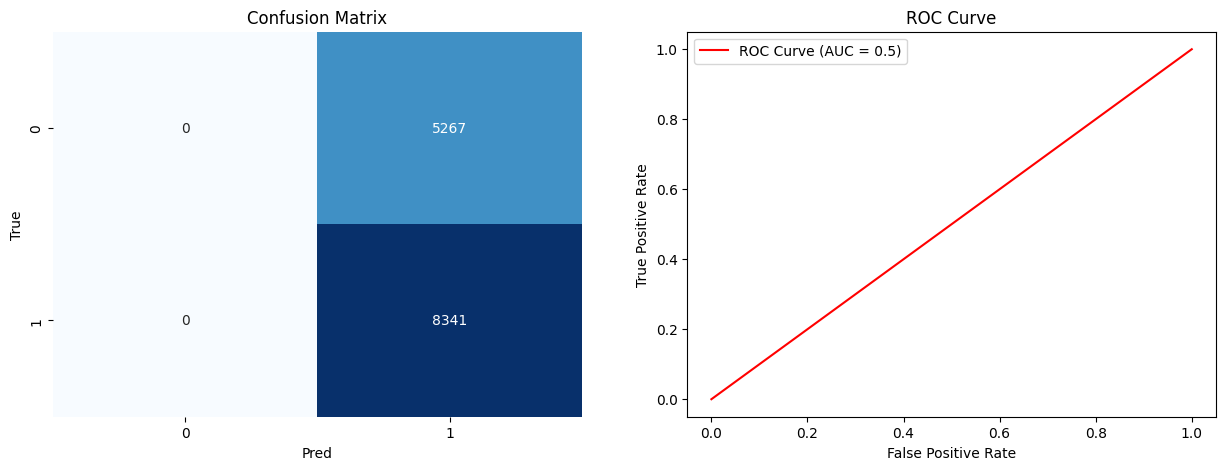

In [5]:
score(
    df_train["label"],
    np.array([majority_label for _ in range(len(df_train))]),
    np.array([[0, 1] for _ in range(len(df_train))])
)

We evaluate the baseline on the dev data.

Accuracy: 0.6289673670093876

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       830
           1      0.629     1.000     0.772      1407

    accuracy                          0.629      2237
   macro avg      0.314     0.500     0.386      2237
weighted avg      0.396     0.629     0.486      2237



/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

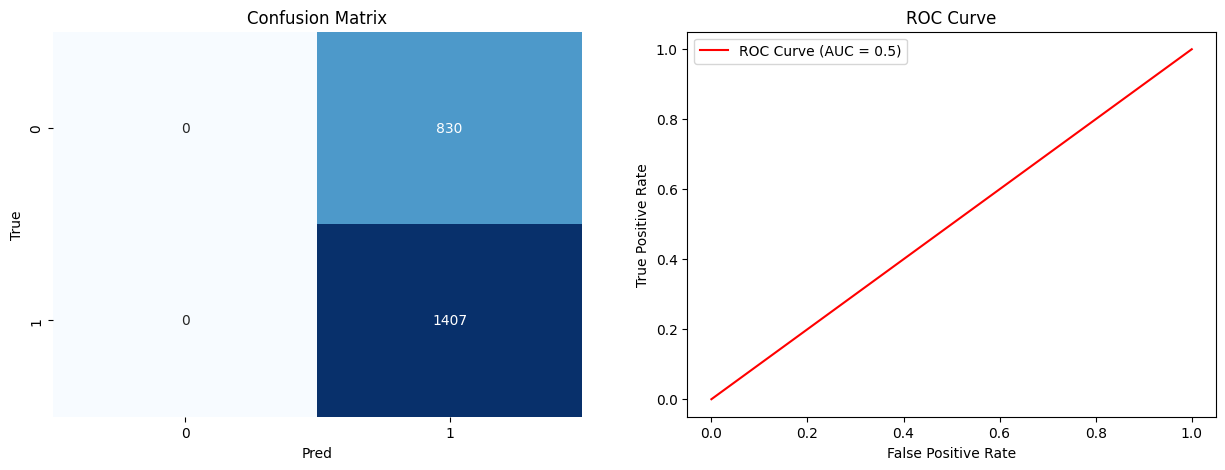

In [6]:
score(
    df_dev["label"],
    np.array([majority_label for _ in range(len(df_dev))]),
    np.array([[0, 1] for _ in range(len(df_dev))])
)

We evaluate the baseline on the test data.

Accuracy: 0.6137684398748323

              precision    recall  f1-score   support

           0      0.000     0.000     0.000       864
           1      0.614     1.000     0.761      1373

    accuracy                          0.614      2237
   macro avg      0.307     0.500     0.380      2237
weighted avg      0.377     0.614     0.467      2237



/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples

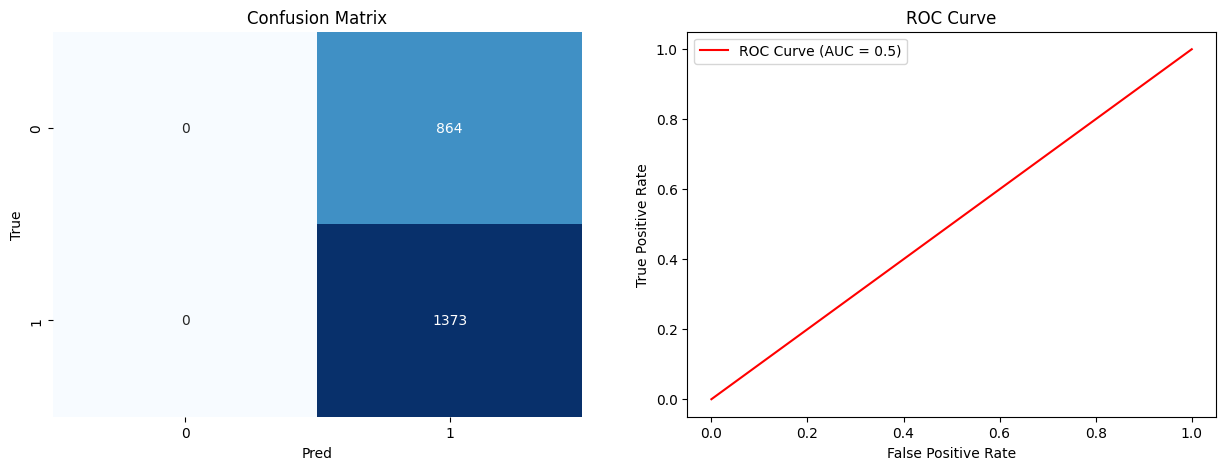

In [7]:
score(
    df_test["label"],
    np.array([majority_label for _ in range(len(df_test))]),
    np.array([[0, 1] for _ in range(len(df_test))])
)

## Strong Baseline

### Text-Only

We generate sentence-transformer (https://www.sbert.net/) embeddings for the text and train a logistic regression model on it.

We load the model.

In [8]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

We generate embeddings for train, dev, and test data.

In [9]:
train_sbert_embeddings = sentence_transformer.encode(
    df_train["tweet_text"], device=device
)
dev_sbert_embeddings = sentence_transformer.encode(
    df_dev["tweet_text"], device=device
)
test_sbert_embeddings = sentence_transformer.encode(
    df_test["tweet_text"], device=device
)

We train a logistic regression model and evaluate it on the train data.

Accuracy: 0.7538947677836567

              precision    recall  f1-score   support

           0      0.735     0.570     0.642      5267
           1      0.762     0.870     0.812      8341

    accuracy                          0.754     13608
   macro avg      0.748     0.720     0.727     13608
weighted avg      0.752     0.754     0.747     13608



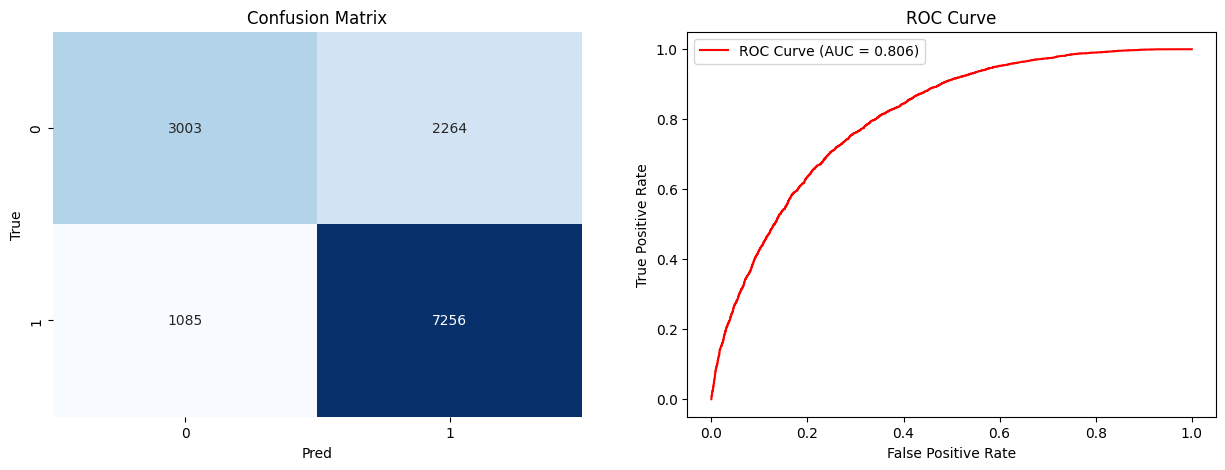

In [10]:
strong_baseline = LogisticRegression(random_state=42)
strong_baseline.fit(train_sbert_embeddings, df_train["label"])

score(
    df_train["label"],
    strong_baseline.predict(train_sbert_embeddings),
    strong_baseline.predict_proba(train_sbert_embeddings)
)

We evaluate the model on the dev data.

Accuracy: 0.7358068842199375

              precision    recall  f1-score   support

           0      0.685     0.534     0.600       830
           1      0.757     0.855     0.803      1407

    accuracy                          0.736      2237
   macro avg      0.721     0.694     0.701      2237
weighted avg      0.730     0.736     0.728      2237



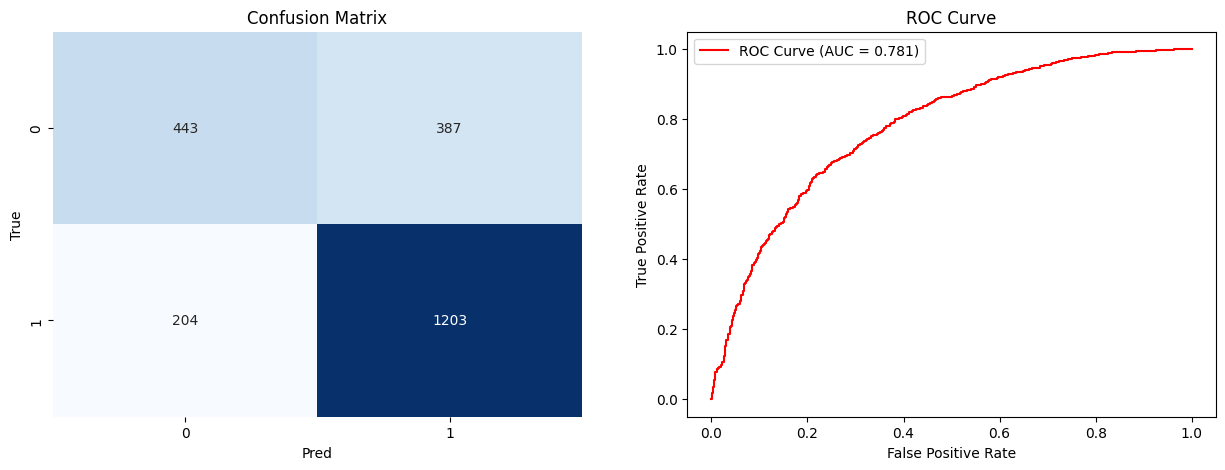

In [11]:
score(
    df_dev["label"],
    strong_baseline.predict(dev_sbert_embeddings),
    strong_baseline.predict_proba(dev_sbert_embeddings)
)

We evaluate the model on the test data.

Accuracy: 0.743406347787215

              precision    recall  f1-score   support

           0      0.724     0.542     0.620       864
           1      0.751     0.870     0.806      1373

    accuracy                          0.743      2237
   macro avg      0.738     0.706     0.713      2237
weighted avg      0.741     0.743     0.734      2237



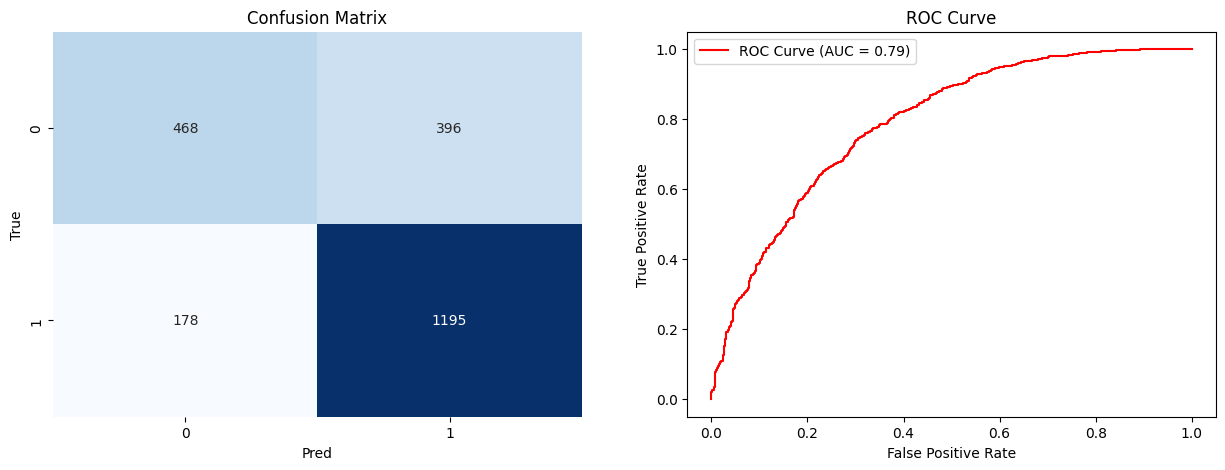

In [12]:
score(
    df_test["label"],
    strong_baseline.predict(test_sbert_embeddings),
    strong_baseline.predict_proba(test_sbert_embeddings)
)

### Image-Only

We fine-tune the classification head of a pretrained VGG16 model using only the image data.

We create train and dev datasets and dataloaders, using default transformations for the images (`torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()`). 

In [13]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, transforms, labels):
        self.image_paths = image_paths
        self.transforms = transforms
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            self.transforms(Image.open(self.image_paths[idx]).convert("RGB")),
            self.labels[idx]
        )

In [14]:
image_transforms = torchvision.models.VGG16_Weights.IMAGENET1K_FEATURES.transforms()

train_dataset = CustomDataset(df_train["image"].tolist(), image_transforms, df_train["label"].tolist())
dev_dataset = CustomDataset(df_dev["image"].tolist(), image_transforms, df_dev["label"].tolist())

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True)

We define the model, adding a single fully-connected layer to the classification head with ReLU activations in-between.

In [15]:
class ImageOnlyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = torchvision.models.vgg16(weights="DEFAULT")

        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(self.vgg16.classifier[6].out_features, 2)

    def forward(self, transformed_image):
        return self.fc(F.relu(self.vgg16(transformed_image)))

We train the model and evaluate it on the dev data.

In [ ]:
image_only_model = ImageOnlyModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(image_only_model.parameters(), lr=1e-4)
epochs = 20

for epoch in range(epochs):
    image_only_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train_samples = 0
    
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = image_only_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train_samples
    avg_train_loss = total_train_loss / len(train_dataloader)
        
    image_only_model.eval()
    total_dev_loss = 0.0
    correct_dev = 0
    total_dev_samples = 0
    
    with torch.no_grad():
        for inputs, labels in dev_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = image_only_model(inputs)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_dev_samples += labels.size(0)
            correct_dev += (predicted == labels).sum().item()
    
    dev_accuracy = 100 * correct_dev / total_dev_samples
    avg_dev_loss = total_dev_loss / len(dev_dataloader)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Accuracy: {train_accuracy:.2f}%, Train Loss: {avg_train_loss:.4f}, Dev Accuracy: {dev_accuracy:.2f}%, Dev Loss: {avg_dev_loss:.4f}")


We save the trained model.

In [ ]:
torch.save(image_only_model.state_dict(), "image_only_model.pth")

We load the saved model and set it to evaluation mode.

In [ ]:
image_only_model = ImageOnlyModel()
image_only_model.load_state_dict(torch.load("image_only_model.pth"))
image_only_model = image_only_model.to(device)
image_only_model.eval()

We recreate the train, dev, and test datasets and dataloaders for evaluation.

In [17]:
train_dataset = CustomDataset(df_train["image"].tolist(), image_transforms, df_train["label"].tolist())
dev_dataset = CustomDataset(df_dev["image"].tolist(), image_transforms, df_dev["label"].tolist())
test_dataset = CustomDataset(df_test["image"].tolist(), image_transforms, df_test["label"].tolist())

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [18]:
def get_outputs(model, dataloader):
    """
    Returns outputs (true, predicted, predicted probabilities) for the image
    only model for evaluation.
    """
    y_true = []
    y_pred = []
    y_pred_proba = []

    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        y_true.extend(labels.tolist())
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_pred_proba.extend(F.softmax(outputs.data, dim=1).tolist())
    
    return np.array(y_true), np.array(y_pred), np.array(y_pred_proba)

We evaluate the model on the train data.

 38%|███▊      | 164/426 [01:03<01:41,  2.57it/s]/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 426/426 [02:44<00:00,  2.59it/s]


Accuracy: 0.6815843621399177

              precision    recall  f1-score   support

           0      0.705     0.305     0.426      5267
           1      0.677     0.919     0.780      8341

    accuracy                          0.682     13608
   macro avg      0.691     0.612     0.603     13608
weighted avg      0.688     0.682     0.643     13608



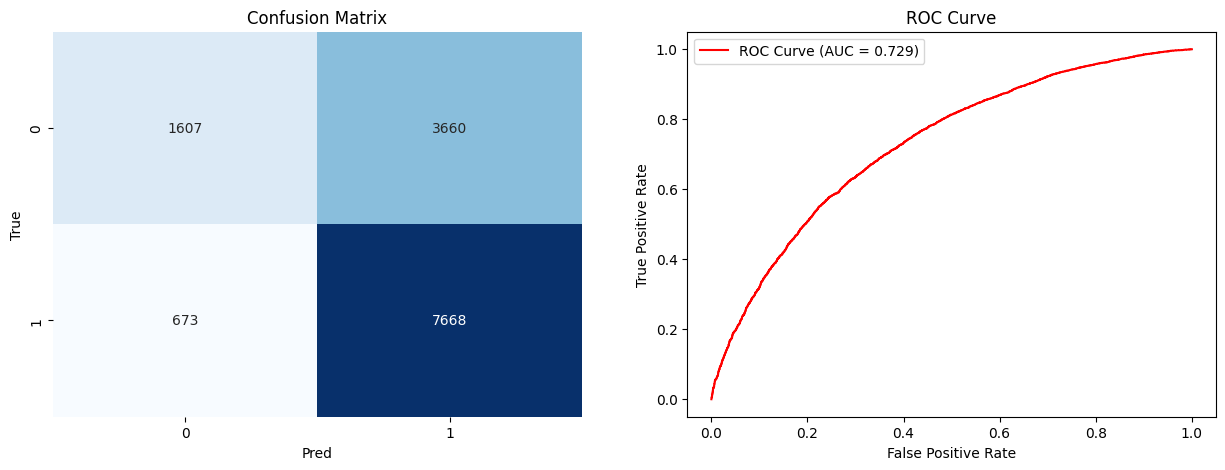

In [19]:
score(*get_outputs(image_only_model, train_dataloader))

We evaluate the model on the dev data.

100%|██████████| 70/70 [00:26<00:00,  2.64it/s]

Accuracy: 0.6727760393383997

              precision    recall  f1-score   support

           0      0.640     0.270     0.380       830
           1      0.679     0.910     0.778      1407

    accuracy                          0.673      2237
   macro avg      0.659     0.590     0.579      2237
weighted avg      0.664     0.673     0.630      2237



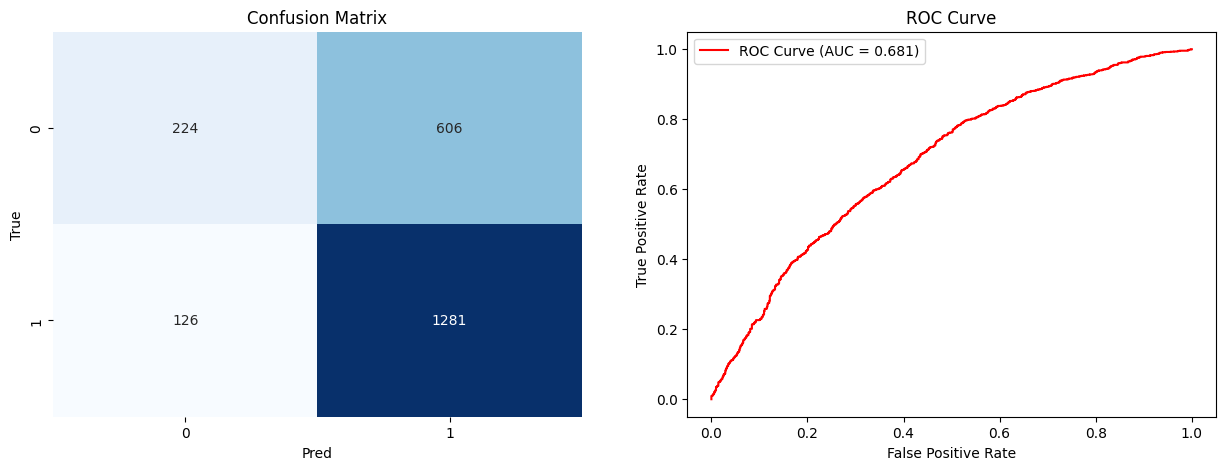

In [20]:
score(*get_outputs(image_only_model, dev_dataloader))

We evaluate the model on the test data.

 26%|██▌       | 18/70 [00:07<00:19,  2.70it/s]/Users/rohan/Projects/multimodal-disaster-tweets-classification/.venv/lib/python3.11/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
100%|██████████| 70/70 [00:26<00:00,  2.66it/s]

Accuracy: 0.6620473848904783

              precision    recall  f1-score   support

           0      0.638     0.289     0.398       864
           1      0.667     0.897     0.765      1373

    accuracy                          0.662      2237
   macro avg      0.652     0.593     0.582      2237
weighted avg      0.656     0.662     0.623      2237



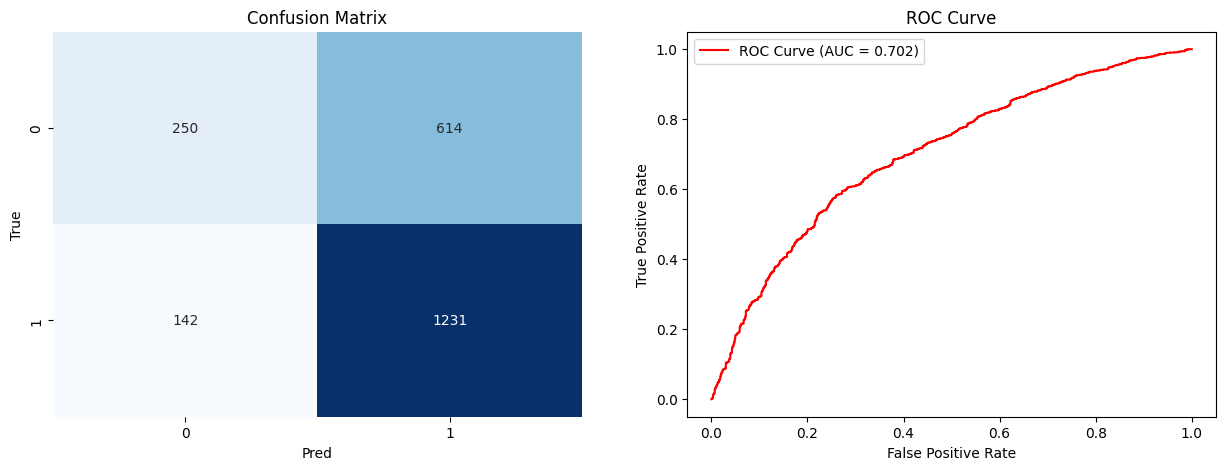

In [21]:
score(*get_outputs(image_only_model, test_dataloader))

## Extension 1

For extension 1 we compare the performance of two different embedding generation strategies.

### CLIP-Concat

We use OpenAI's ViT-B/32 CLIP (Contrastive Language-Image Pre-Training) model (https://github.com/openai/CLIP), a neural network trained on a variety of (image, text) pairs. We use the model to generate text and image embeddings for each tweet-image pair, and concatenate the generated embeddings. We then train an elastic net model with different choices of `l1_ratio` to predict the output label and look for the model that maximizes the dev accuracy/F-score.

We load the model.

In [4]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|███████████████████████████████████████| 338M/338M [00:29<00:00, 11.9MiB/s]


We generate and save embeddings for the train, dev, and test data.

In [5]:
def generate_clip_embeddings(df: pd.DataFrame, batch_size: int=64) -> list[list[float]]:
    """
    Generates and concatenates image and text CLIP embeddings for `df`.
    """
    embeddings = []

    for i in tqdm(range(0, len(df), batch_size)):
        image_batch = torch.cat([
            preprocess(Image.open(file_path).convert("RGB")).unsqueeze(0)
            for file_path in df["image"][i : i + batch_size]
        ]).to(device)
        text_batch = clip.tokenize(
            df["tweet_text"][i : i + batch_size], truncate=True
        ).to(device)

        with torch.no_grad():
            image_batch_features = clip_model.encode_image(image_batch)
            text_batch_features = clip_model.encode_text(text_batch)

        embeddings.extend(torch.cat(
            (image_batch_features, text_batch_features), axis=1
        ).tolist())

    return embeddings

In [ ]:
with open("train_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_train), f)

with open("dev_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_dev), f)

with open("test_clip_embeddings.pkl", mode="wb") as f:
    pickle.dump(generate_clip_embeddings(df_test), f)

We load the embeddings.

In [22]:
with open("train_clip_embeddings.pkl", mode="rb") as f:
    train_clip_embeddings = pickle.load(f)

with open("dev_clip_embeddings.pkl", mode="rb") as f:
    dev_clip_embeddings = pickle.load(f)

with open("test_clip_embeddings.pkl", mode="rb") as f:
    test_clip_embeddings = pickle.load(f)

We train an elastic net model with hyperparameter tuning.

In [ ]:
for l1_ratio in [0, 0.25, 0.5, 0.75, 1.0]:
    clip_concat = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    clip_concat.fit(train_clip_embeddings, df_train["label"])

    train_y_pred = clip_concat.predict(train_clip_embeddings)
    train_accuracy = metrics.accuracy_score(y_true=df_train["label"], y_pred=train_y_pred)
    train_precision, train_recall, train_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_train["label"], y_pred=train_y_pred, average="macro"
    )
    print(f"Train | l1_ratio: {l1_ratio} | Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F-Score: {train_fscore}")

    dev_y_pred = clip_concat.predict(dev_clip_embeddings)
    dev_accuracy = metrics.accuracy_score(y_true=df_dev["label"], y_pred=dev_y_pred)
    dev_precision, dev_recall, dev_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_dev["label"], y_pred=dev_y_pred, average="macro"
    )
    print(f"Dev   | l1_ratio: {l1_ratio} | Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F-Score: {dev_fscore}")

The model with `l1_ratio = 0` marginally shows the best dev performance. We retrain the model with this parameter and evaluate it on the train data.

Accuracy: 0.8288506760728983

              precision    recall  f1-score   support

           0      0.797     0.748     0.772      5267
           1      0.847     0.880     0.863      8341

    accuracy                          0.829     13608
   macro avg      0.822     0.814     0.817     13608
weighted avg      0.828     0.829     0.828     13608



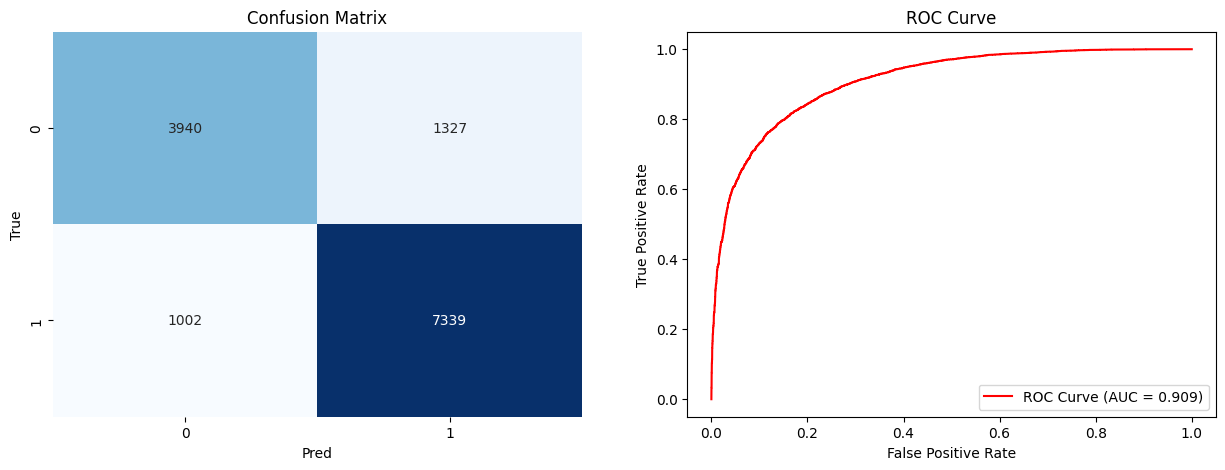

In [23]:
clip_concat = LogisticRegression(
    penalty="elasticnet",
    random_state=42,
    solver="saga",
    max_iter=1000,
    l1_ratio=0
)
clip_concat.fit(train_clip_embeddings, df_train["label"])

score(
    df_train["label"],
    clip_concat.predict(train_clip_embeddings),
    clip_concat.predict_proba(train_clip_embeddings)
)

We evaluate the model on the dev data.

Accuracy: 0.805543138131426

              precision    recall  f1-score   support

           0      0.747     0.719     0.733       830
           1      0.838     0.856     0.847      1407

    accuracy                          0.806      2237
   macro avg      0.793     0.788     0.790      2237
weighted avg      0.804     0.806     0.805      2237



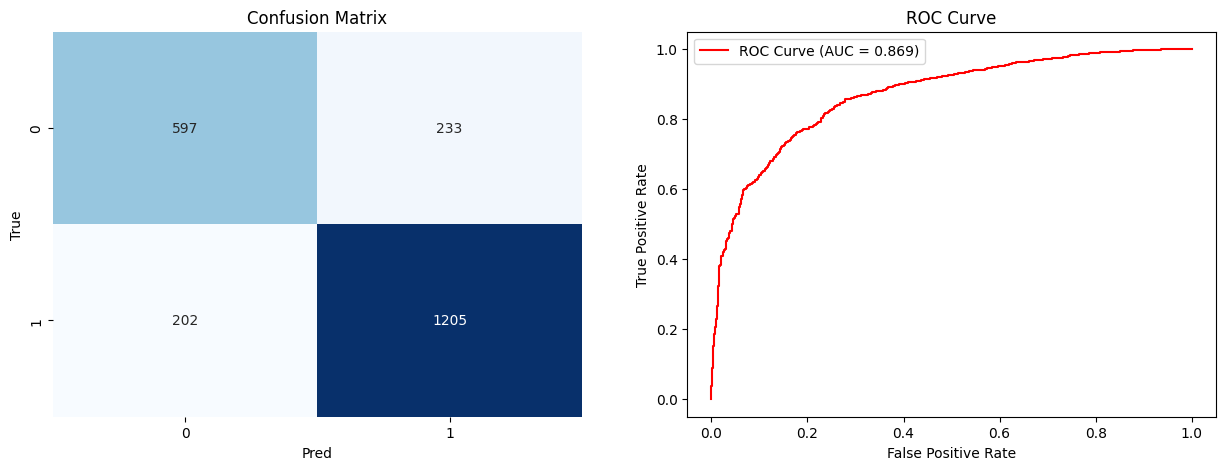

In [24]:
score(
    df_dev["label"],
    clip_concat.predict(dev_clip_embeddings),
    clip_concat.predict_proba(dev_clip_embeddings)
)

We evaluate the model on the test data.

Accuracy: 0.7845328565042468

              precision    recall  f1-score   support

           0      0.736     0.690     0.712       864
           1      0.812     0.844     0.828      1373

    accuracy                          0.785      2237
   macro avg      0.774     0.767     0.770      2237
weighted avg      0.783     0.785     0.783      2237



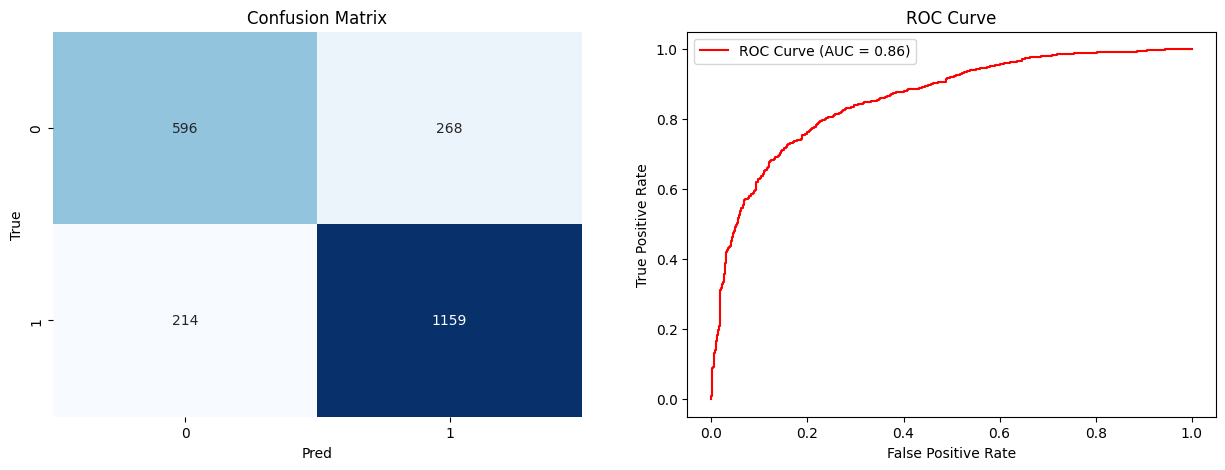

In [25]:
score(
    df_test["label"],
    clip_concat.predict(test_clip_embeddings),
    clip_concat.predict_proba(test_clip_embeddings)
)

### Text + Captions + S-BERT

We use Salesforce's BLIP (Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation) framework (https://github.com/salesforce/BLIP) to generate image captions using nucleus sampling. Given a tweet-image pair, and generated image caption `caption`, we augment the tweet text as `Tweet: tweet_text\n Image Caption: caption`. Finally, we generate sentence-transformer (https://www.sbert.net/) embeddings for the augmented text using the `all-MiniLM-L6-v2` model. We then train an elastic net model with different choices of `l1_ratio` to predict the output label and look for the model that maximizes the dev accuracy/F-score.

In [ ]:
!git clone https://github.com/salesforce/BLIP

In [ ]:
cd BLIP

We load the model.

In [ ]:
from models.blip import blip_decoder

blip_model = blip_decoder(
    pretrained="https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth",
    image_size=384,
    vit="base"
).to(device)

blip_model.eval()

We generate and save image captions.

In [18]:
transform = transforms.Compose([
    transforms.Resize((384, 384),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor()
])

def generate_blip_captions(df: pd.DataFrame, batch_size: int=64) -> list[str]:
    """
    Generates BLIP image captions for `df`.
    """
    captions = []

    for i in tqdm(range(0, len(df), batch_size)):
        image_batch = torch.cat([
            transform(Image.open(file_path).convert("RGB")).unsqueeze(0)
            for file_path in df["image"][i : i + batch_size].apply(
                lambda s: os.path.join("..", s)
            ).tolist()
        ]).to(device)

        with torch.no_grad():
            captions.extend(blip_model.generate(
                image_batch,
                sample=True,
                top_p=0.9,
                max_length=20,
                min_length=5
            ))

    return captions

In [ ]:
df_train["image_caption"] = generate_blip_captions(df_train)
df_train.to_csv("../train_with_captions.csv", index=False)

df_dev["image_caption"] = generate_blip_captions(df_dev)
df_dev.to_csv("../dev_with_captions.csv", index=False)

df_test["image_caption"] = generate_blip_captions(df_test)
df_test.to_csv("../test_with_captions.csv", index=False)

In [ ]:
cd ..

We load the data with captions and concatenate the captions with the text.

In [26]:
df_train_with_captions = pd.read_csv("train_with_captions.csv")
df_dev_with_captions = pd.read_csv("dev_with_captions.csv")
df_test_with_captions = pd.read_csv("test_with_captions.csv")

df_train_with_captions["tweet_text_with_captions"] = df_train_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_dev_with_captions["tweet_text_with_captions"] = df_dev_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)
df_test_with_captions["tweet_text_with_captions"] = df_test_with_captions.apply(
    lambda row: f"Tweet: {row['tweet_text']}\nImage Caption: {row['image_caption']}", axis=1)

We load the sentence-transformer model.

In [ ]:
sentence_transformer = SentenceTransformer('all-MiniLM-L6-v2')

We generate and save embeddings for the text with captions.

In [ ]:
with open("train_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_train_with_captions["tweet_text_with_captions"], device=device
    ), f)

with open("dev_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_dev_with_captions["tweet_text_with_captions"], device=device
    ), f)

with open("test_with_captions_sbert_embeddings.pkl", mode="wb") as f:
    pickle.dump(sentence_transformer.encode(
        df_test_with_captions["tweet_text_with_captions"], device=device
    ), f)

We load the embeddings.

In [27]:
with open("train_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    train_with_captions_sbert_embeddings = pickle.load(f)

with open("dev_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    dev_with_captions_sbert_embeddings = pickle.load(f)

with open("test_with_captions_sbert_embeddings.pkl", mode="rb") as f:
    test_with_captions_sbert_embeddings = pickle.load(f)

We train an elastic net model with hyperparameter tuning.

In [ ]:
for l1_ratio in [0, 0.25, 0.5, 0.75, 1.0]:
    text_captions_sbert = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=l1_ratio)
    text_captions_sbert.fit(train_with_captions_sbert_embeddings, df_train_with_captions["label"])

    train_y_pred = text_captions_sbert.predict(train_with_captions_sbert_embeddings)
    train_accuracy = metrics.accuracy_score(y_true=df_train_with_captions["label"], y_pred=train_y_pred)
    train_precision, train_recall, train_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_train_with_captions["label"], y_pred=train_y_pred, average="macro"
    )
    print(f"Train | l1_ratio: {l1_ratio} | Accuracy: {train_accuracy}, Precision: {train_precision}, Recall: {train_recall}, F-Score: {train_fscore}")

    dev_y_pred = text_captions_sbert.predict(dev_with_captions_sbert_embeddings)
    dev_accuracy = metrics.accuracy_score(y_true=df_dev_with_captions["label"], y_pred=dev_y_pred)
    dev_precision, dev_recall, dev_fscore, _ = metrics.precision_recall_fscore_support(
        y_true=df_dev_with_captions["label"], y_pred=dev_y_pred, average="macro"
    )
    print(f"Dev   | l1_ratio: {l1_ratio} | Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F-Score: {dev_fscore}")

The model with `l1_ratio = 0` marginally shows the best dev performance. We retrain the model with this parameter and evaluate it on the train data.

Accuracy: 0.7827748383303939

              precision    recall  f1-score   support

           0      0.763     0.636     0.694      5267
           1      0.792     0.875     0.832      8341

    accuracy                          0.783     13608
   macro avg      0.778     0.756     0.763     13608
weighted avg      0.781     0.783     0.778     13608



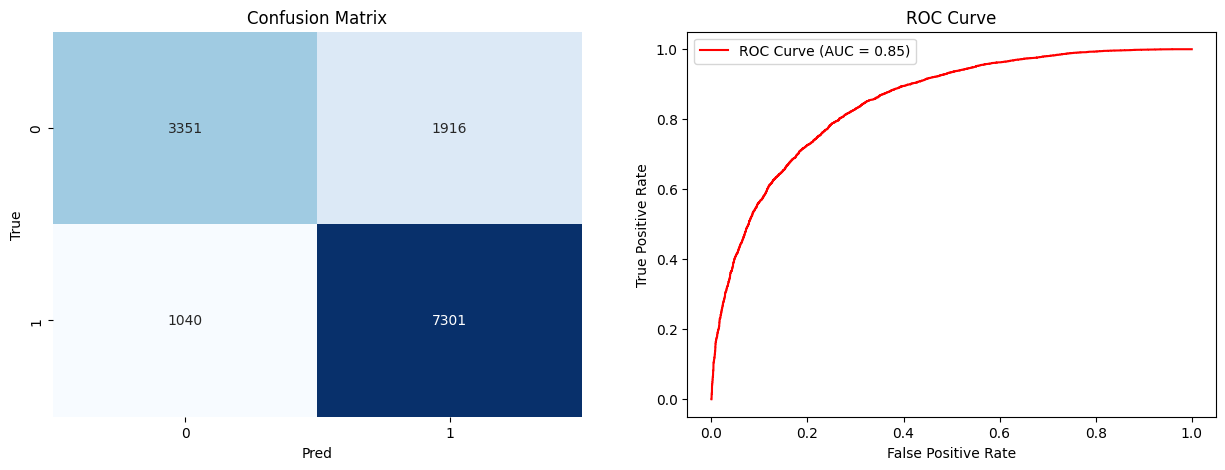

In [28]:
text_captions_sbert = LogisticRegression(penalty="elasticnet", random_state=42, solver="saga", max_iter=1000, l1_ratio=0)
text_captions_sbert.fit(train_with_captions_sbert_embeddings, df_train_with_captions["label"])

score(
    df_train_with_captions["label"],
    text_captions_sbert.predict(train_with_captions_sbert_embeddings),
    text_captions_sbert.predict_proba(train_with_captions_sbert_embeddings)
)

We evaluate the model on the dev data.

Accuracy: 0.7590523021904336

              precision    recall  f1-score   support

           0      0.711     0.592     0.646       830
           1      0.781     0.858     0.817      1407

    accuracy                          0.759      2237
   macro avg      0.746     0.725     0.732      2237
weighted avg      0.755     0.759     0.754      2237



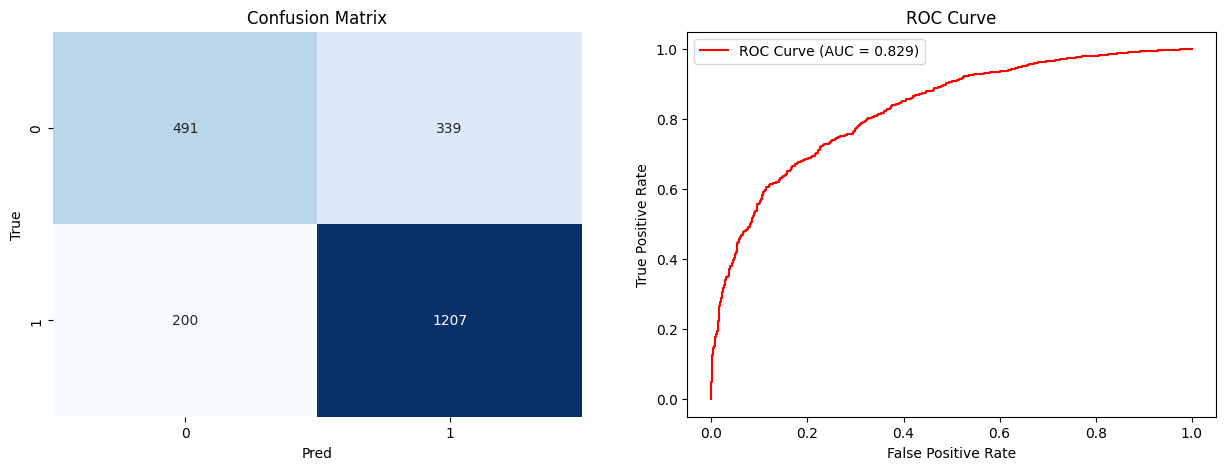

In [29]:
score(
    df_dev_with_captions["label"],
    text_captions_sbert.predict(dev_with_captions_sbert_embeddings),
    text_captions_sbert.predict_proba(dev_with_captions_sbert_embeddings)
)

We evaluate the model on the test data.

Accuracy: 0.7657577112203845

              precision    recall  f1-score   support

           0      0.735     0.615     0.670       864
           1      0.780     0.861     0.819      1373

    accuracy                          0.766      2237
   macro avg      0.758     0.738     0.744      2237
weighted avg      0.763     0.766     0.761      2237



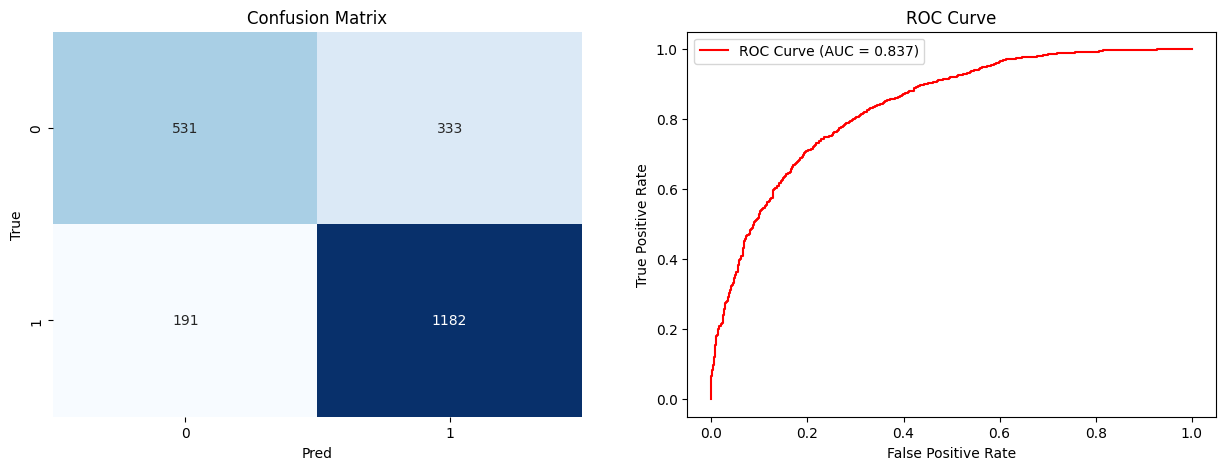

In [30]:
score(
    df_test_with_captions["label"],
    text_captions_sbert.predict(test_with_captions_sbert_embeddings),
    text_captions_sbert.predict_proba(test_with_captions_sbert_embeddings)
)

## Extension 2

We train an attention-based model on the CLIP embeddings, also adding in information for the event names.

We recode the event names.

In [31]:
events = {
    'california_wildfires': 0,
    'srilanka_floods': 1,
    'mexico_earthquake': 2,
    'iraq_iran_earthquake': 3,
    'hurricane_harvey': 4,
    'hurricane_maria': 5,
    'hurricane_irma': 6
}

df_train["event_name"] = df_train["event_name"].apply(lambda s: events[s])
df_dev["event_name"] = df_dev["event_name"].apply(lambda s: events[s])
df_test["event_name"] = df_test["event_name"].apply(lambda s: events[s])

We load the CLIP embeddings.

In [32]:
with open("train_clip_embeddings.pkl", mode="rb") as f:
    train_clip_embeddings = torch.tensor(pickle.load(f)).to(device)

with open("dev_clip_embeddings.pkl", mode="rb") as f:
    dev_clip_embeddings = torch.tensor(pickle.load(f)).to(device)

with open("test_clip_embeddings.pkl", mode="rb") as f:
    test_clip_embeddings = torch.tensor(pickle.load(f)).to(device)

We split the train and dev CLIP embeddings into image and text embeddings.

In [33]:
train_image_embeddings = train_clip_embeddings[:, :512]
train_text_embeddings = train_clip_embeddings[:, 512:]
dev_image_embeddings = dev_clip_embeddings[:, :512]
dev_text_embeddings = dev_clip_embeddings[:, 512:]

We create train and dev datasets and dataloaders.

In [34]:
class CustomDataset(Dataset):
    def __init__(self, text_embeddings, image_embeddings, events, labels):
        super().__init__()

        self.text_embeddings = text_embeddings
        self.image_embeddings = image_embeddings
        self.events = events
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return (
            self.text_embeddings[idx],
            self.image_embeddings[idx],
            self.events[idx],
            self.labels[idx]
        )

In [21]:
train_dataset = CustomDataset(
    train_text_embeddings, train_image_embeddings, df_train["event_name"].tolist(), df_train["label"].tolist()
)
dev_dataset = CustomDataset(
    dev_text_embeddings, dev_image_embeddings, df_dev["event_name"].tolist(), df_dev["label"].tolist()
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=True)

We define the attention model.

In [35]:
class AttentionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.text_embedding = nn.Linear(512, 256)
        self.image_embedding = nn.Linear(512, 256)
        self.event_embedding = nn.Embedding(7, 32)
        self.text_attention = nn.Linear(256, 256)
        self.image_attention = nn.Linear(256, 256)
        self.event_attention = nn.Linear(32, 32)
        self.fc1 = nn.Linear(544, 128)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 16)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(16, 2)

    def forward(self, text_embeddings, image_embeddings, events):
        text_output = F.gelu(self.text_embedding(text_embeddings))
        image_output = F.gelu(self.image_embedding(image_embeddings))
        event_output = F.gelu(self.event_embedding(events))
        text_attention_weights = F.softmax(self.text_attention(text_output), dim=1)
        image_attention_weights = F.softmax(self.image_attention(image_output), dim=1)
        event_attention_weights = F.softmax(self.event_attention(event_output), dim=1)

        text_attention_output = text_output * text_attention_weights
        image_attention_output = image_output * image_attention_weights
        event_attention_output = event_output * event_attention_weights
        output = torch.cat((text_attention_output, image_attention_output, event_attention_output), dim=1)
        output = F.gelu(self.fc1(output))
        output = self.dropout1(output)
        output = F.gelu(self.fc2(output))
        output = self.dropout2(output)
        output = self.fc3(output)
        return output

In [24]:
attention_model = AttentionModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(attention_model.parameters(), lr=1e-5) 
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=25, factor=0.1, verbose=True)

max_epochs = 1000
no_improvement_count = 0
best_accuracy = 0.0

for epoch in range(max_epochs):
    attention_model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train_samples = 0
    
    for (text_embeddings, image_embeddings, events, labels) in train_dataloader:
        text_embeddings, image_embeddings, events, labels = text_embeddings.to(device), image_embeddings.to(device), events.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = attention_model(text_embeddings, image_embeddings, events)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()        
        
        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train_samples += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_accuracy = 100 * correct_train / total_train_samples
    avg_train_loss = total_train_loss / len(train_dataloader)
        
    attention_model.eval()
    total_dev_loss = 0.0
    correct_dev = 0
    total_dev_samples = 0
    
    with torch.no_grad():
        for (text_embeddings, image_embeddings, events, labels) in dev_dataloader:
            text_embeddings, image_embeddings, events, labels = text_embeddings.to(device), image_embeddings.to(device), events.to(device), labels.to(device)
            outputs = attention_model(text_embeddings, image_embeddings, events)
            loss = criterion(outputs, labels)
            total_dev_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_dev_samples += labels.size(0)
            correct_dev += (predicted == labels).sum().item()
    
    dev_accuracy = 100 * correct_dev / total_dev_samples
    avg_dev_loss = total_dev_loss / len(dev_dataloader)
    
    print(f"Epoch {epoch + 1}/{max_epochs}, Train Accuracy: {train_accuracy:.2f}%, Train Loss: {avg_train_loss:.4f}, Dev Accuracy: {dev_accuracy:.2f}%, Dev Loss: {avg_dev_loss:.4f}")
    
    # Check for early stopping
    if dev_accuracy > best_accuracy:
        best_accuracy = dev_accuracy
        no_improvement_count = 0
    else:
        no_improvement_count += 1

    # Adjust learning rate if needed
    lr_scheduler.step(dev_accuracy)

    if (epoch != 0 and epoch % 100 == 0):
        torch.save(attention_model.state_dict(), f"attention_model_{epoch}.pth")

    # Check early stopping criterion
    if no_improvement_count >= 25:
        print("Early stopping as there has been no improvement for 25 epochs.")
        break


Epoch 1/1000, Train Accuracy: 38.71%, Train Loss: 0.7104, Dev Accuracy: 37.10%, Dev Loss: 0.7104
Epoch 2/1000, Train Accuracy: 38.71%, Train Loss: 0.7064, Dev Accuracy: 37.10%, Dev Loss: 0.7046
Epoch 3/1000, Train Accuracy: 46.03%, Train Loss: 0.6949, Dev Accuracy: 74.92%, Dev Loss: 0.6811
Epoch 4/1000, Train Accuracy: 70.47%, Train Loss: 0.6642, Dev Accuracy: 69.29%, Dev Loss: 0.6411
Epoch 5/1000, Train Accuracy: 68.36%, Train Loss: 0.6290, Dev Accuracy: 68.35%, Dev Loss: 0.6044
Epoch 6/1000, Train Accuracy: 68.86%, Train Loss: 0.6018, Dev Accuracy: 70.05%, Dev Loss: 0.5754
Epoch 7/1000, Train Accuracy: 71.65%, Train Loss: 0.5770, Dev Accuracy: 72.28%, Dev Loss: 0.5509
Epoch 8/1000, Train Accuracy: 74.47%, Train Loss: 0.5594, Dev Accuracy: 74.12%, Dev Loss: 0.5309
Epoch 9/1000, Train Accuracy: 76.22%, Train Loss: 0.5449, Dev Accuracy: 75.82%, Dev Loss: 0.5142
Epoch 10/1000, Train Accuracy: 78.08%, Train Loss: 0.5297, Dev Accuracy: 77.11%, Dev Loss: 0.4982
Epoch 11/1000, Train Accuracy

We save the trained model.

In [25]:
torch.save(attention_model.state_dict(), "attention_model_final.pth")

We load the saved model and set it to evaluation mode.

In [36]:
attention_model = AttentionModel()
attention_model.load_state_dict(torch.load("attention_model_final.pth"))
attention_model = attention_model.to(device)
attention_model.eval()

AttentionModel(
  (text_embedding): Linear(in_features=512, out_features=256, bias=True)
  (image_embedding): Linear(in_features=512, out_features=256, bias=True)
  (event_embedding): Embedding(7, 32)
  (text_attention): Linear(in_features=256, out_features=256, bias=True)
  (image_attention): Linear(in_features=256, out_features=256, bias=True)
  (event_attention): Linear(in_features=32, out_features=32, bias=True)
  (fc1): Linear(in_features=544, out_features=128, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

We recreate the train, dev, and test datasets and dataloaders.

In [39]:
test_image_embeddings = test_clip_embeddings[:, :512]
test_text_embeddings = test_clip_embeddings[:, 512:]

train_dataset = CustomDataset(
    train_text_embeddings, train_image_embeddings, df_train["event_name"].tolist(), df_train["label"].tolist()
)
dev_dataset = CustomDataset(
    dev_text_embeddings, dev_image_embeddings, df_dev["event_name"].tolist(), df_dev["label"].tolist()
)
test_dataset = CustomDataset(
    test_text_embeddings, test_image_embeddings, df_test["event_name"].tolist(), df_test["label"].tolist()
)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)
dev_dataloader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
def get_outputs(model, dataloader):
    """
    Returns outputs (true, predicted, predicted probabilities) for the image
    only model for evaluation.    
    """
    y_true = []
    y_pred = []
    y_pred_proba = []

    for text_embeddings, image_embeddings, events, labels in tqdm(dataloader):
        text_embeddings = text_embeddings.to(device)
        image_embeddings = image_embeddings.to(device)
        events = events.to(device)
        labels = labels.to(device)
        outputs = model(text_embeddings, image_embeddings, events)
        y_true.extend(labels.tolist())
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.tolist())
        y_pred_proba.extend(F.softmax(outputs.data, dim=1).tolist())
    
    return np.array(y_true), np.array(y_pred), np.array(y_pred_proba)

We evaluate the model on the train data.

100%|██████████| 426/426 [00:01<00:00, 234.86it/s]


Accuracy: 0.8239271017048795

              precision    recall  f1-score   support

           0      0.787     0.748     0.767      5267
           1      0.846     0.872     0.859      8341

    accuracy                          0.824     13608
   macro avg      0.816     0.810     0.813     13608
weighted avg      0.823     0.824     0.823     13608



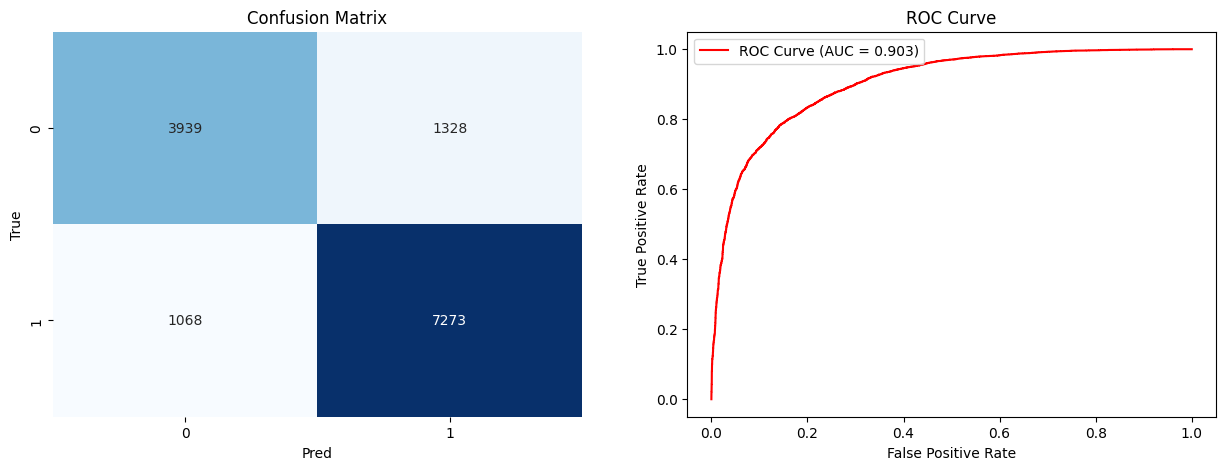

In [41]:
score(*get_outputs(attention_model, train_dataloader))

We evaluate the model on the dev data.

100%|██████████| 70/70 [00:00<00:00, 186.43it/s]


Accuracy: 0.8033080017881091

              precision    recall  f1-score   support

           0      0.741     0.723     0.732       830
           1      0.839     0.851     0.845      1407

    accuracy                          0.803      2237
   macro avg      0.790     0.787     0.788      2237
weighted avg      0.802     0.803     0.803      2237



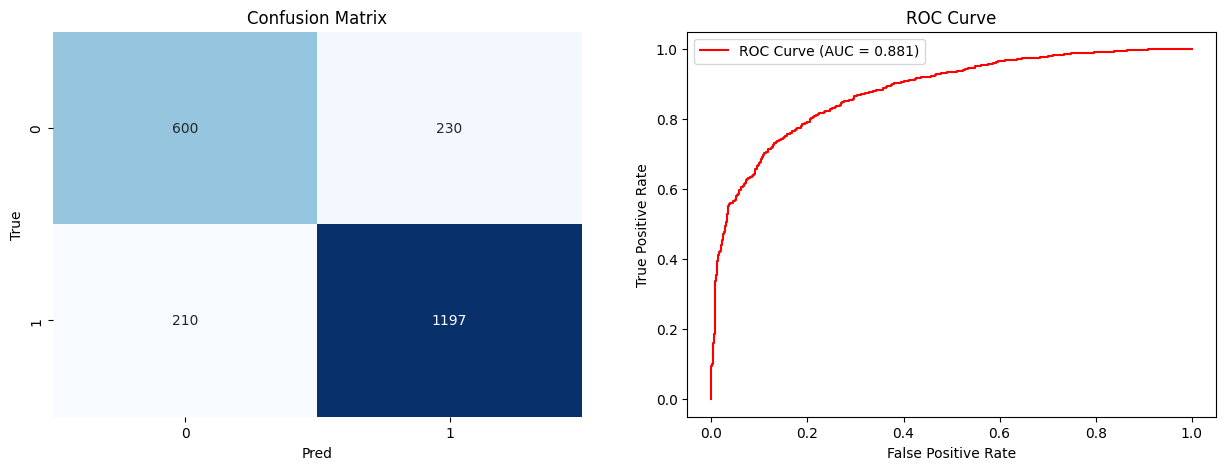

In [42]:
score(*get_outputs(attention_model, dev_dataloader))

We evaluate the model on the test data.

100%|██████████| 70/70 [00:00<00:00, 241.21it/s]


Accuracy: 0.7867679928475637

              precision    recall  f1-score   support

           0      0.733     0.704     0.718       864
           1      0.818     0.839     0.828      1373

    accuracy                          0.787      2237
   macro avg      0.776     0.771     0.773      2237
weighted avg      0.785     0.787     0.786      2237



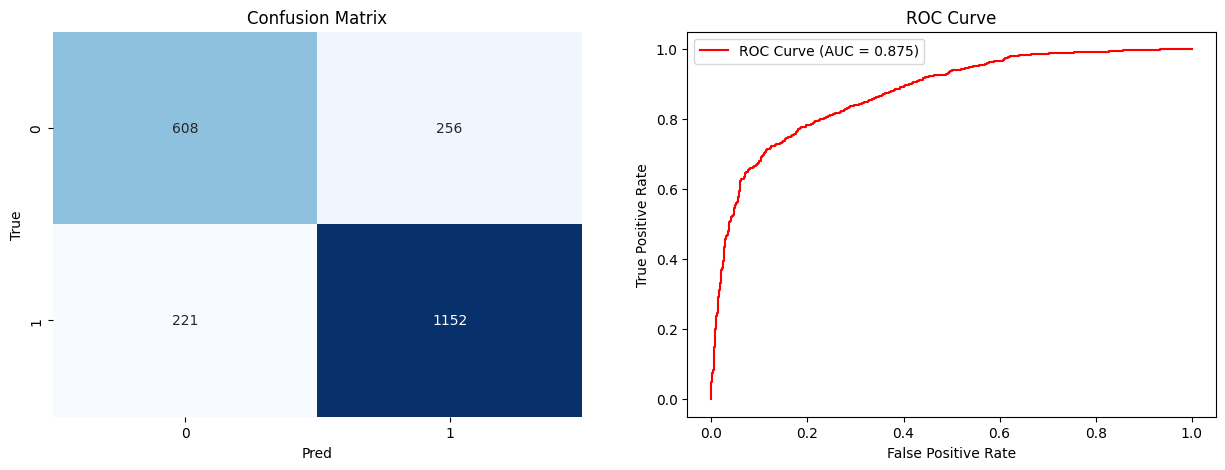

In [43]:
score(*get_outputs(attention_model, test_dataloader))